# ML/DL techniques for Tabular Modeling PART II

- toc: true 
- badges: true
- comments: true

In [80]:
#hide
# write about bagging, rf, give predcition on kaggle dataset for dt, rf. Give 5 refinements and metrices for rf. In the end show same extrapolition problem.

In [1]:
#hide
# !pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

/home/nitish/miniconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [32]:
#hide
df = pd.read_csv('/home/nitish/Downloads/bluebook-bulldozers/TrainAndValid.csv', low_memory=False)

## Introduction
Hello everyone, in [PART I](https://nitishsadire.github.io/DLblog/2020/11/10/DLforCNN.html) we have read and implemented a decision tree on a very simple dataset, and have seen it's poor extrapolation power. Now we will look into a much better model than the decision tree but fundamentally similar, known as Random Forest (RF). But before RF let's look into bagging.

### Bagging
We have seen in [PART I](https://nitishsadire.github.io/DLblog/2020/11/10/DLforCNN.html) that a decision tree model has high variance and low bias, and by high variance, it means the variance of the predictions given by the model. In order to reduce this variance, multiple decision trees on a randomly sampled subset of the training dataset are modeled, and predictions are based on the average of predictions of all the decision trees. The algorithm is as follows:
1. Randomly sample some rows from the training dataset, these are known as bootstrap replicas.
1. Implement and train a decision tree from the dataset taken in (1).
1. Save the model and repeat steps 1, 2 multiple times.
1. At the time of prediction, take the average of predictions of all the decision trees. 

This is beneficial because now the error will also average out which will lead to lesser variance. 
Mathematically, If we draw n independent samples of X where $X_i \in N(0, 1)$, then $\Sigma_{i=1}^n X_i \in N(0, \frac{1}{n})$. This is the basic idea behind bagging. If we train multiple decision trees on an independently drawn training set then averaging out their predictions will give the same mean but lesser variance. 

The independence of training sets is a very important condition otherwise the variance won't be any lesser. For example, if we have trained multiple decision trees on the same set of data then more or less all the decision trees will have the same shape and will give similar predictions, or highly correlated predictions. Therefore averaging won't be beneficial.

## Random Forests
In RF, we not only sample random rows of data like bagging but also sample the columns to be included. Then train decision tree on this randomly sampled dataset. Repeat the same procedure and create multiple decision trees. In comparison with the previous approach, Bagging is choosing random rows to make models, and taking average at the end, RF randomly choosing rows as well as columns.

In [33]:
#hide
sizes = ('Large','Large / Medium','Medium','Small','Mini','Compact')
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])
df = add_datepart(df, 'saledate')
procs = [Categorify, FillMissing]
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))


cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)


In [42]:
#hide
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [44]:
#hide
xs.loc[xs['YearMade']<1950, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1950, 'YearMade'] = 1950

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

If we model the decision tree on the Kaggle dataset, then it gives the following result:

In [47]:
m = DecisionTreeRegressor(max_leaf_nodes=10000)
m.fit(xs, y);

print(f'Training error {m_rmse(m, xs, y)}, Validation Error{m_rmse(m, valid_xs, valid_y)}')

Training error 0.191348, Validation Error0.280134


Whereas the RF gives far better training loss, validation loss, and less overfitting.

In [48]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
m = rf(xs, y)

print(f'Training error {m_rmse(m, xs, y)}, Validation Error{m_rmse(m, valid_xs, valid_y)}')

Training error 0.171021, Validation Error0.234668


Here I have passed 40 decision trees (n_estimators), with max_samples 200k, and max features are half of the total features available. To see how RF is better than decision trees, we need to get validation loss values for different n_estimators values.

In [49]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Text(0, 0.5, 'Validation Loss')

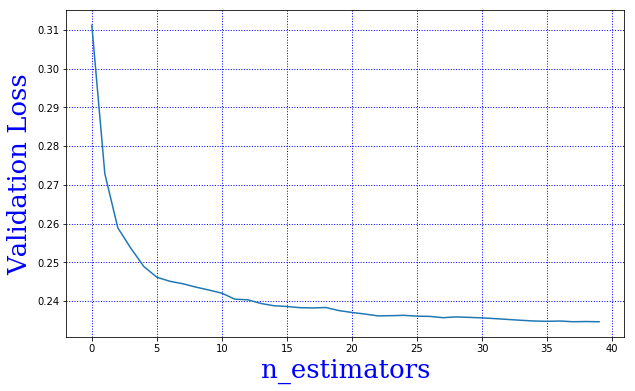

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot( range(40), [r_mse(preds[:i+1].mean(axis=0), valid_y) for i in range(40)])
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.grid(which='major', axis='both', linestyle=':', linewidth = 1, color='b')


ax.set_xlabel("n_estimators", labelpad=5, fontsize=26, fontname='serif', color="blue")
ax.set_ylabel("Validation Loss", labelpad=5, fontsize=26, fontname='serif', color="blue")


It could be clearly seen as the number of estimators increase there is a decrease in validation loss, which gets stable for n_estimators > 30.

### Out-Of-Bag Error (OOB)
We know that in a decision tree in RF we sample rows from the training set. The rows which are not selected for a decision tree could be thought of as a validation dataset for that decision tree model because that data was not used during training. Computing loss on such rows that were not seen during the training is known as OOB error. The benefit of this approach is we do not need to partition the whole data into 2 subsets of training and validation dataset. This is particularly useful in case of less data is available. 

If say row-i is not included in 10 decision trees out of 40, then we will pass row-i to those 10 decision trees and take the average to get OOB prediction. 

In [51]:
r_mse(m.oob_prediction_, y)

0.210836

## Model Refinements

### Prediction Confidence
When a model makes a prediction, we want to know how confident the model is in the prediction. It could be used as we will use that prediction only when the model has a certain degree of confidence in the prediction. 

We know in RF there are multiple decision tree models, all of which make predictions and an average is taken out which is the final prediction of the RF model. So, if there are n decision trees, we will have n predictions, we could then take variance or standard deviation (std) of these n predictions. It tells us how sure or unsure the RF is because if the std is high, then all the models are not making very similar predictions, and vice versa. The benefit of this is we could be more cautious while use predictions that have high std.

### Feature Importance

If we want to know which feature is the most important in our decision tree, or whether feature a is more important or not than the feature b. The answer to this question could be find out from the decision tree. In a decision tree, a split is used to partition the root dataset into two disjoint subsets. If we look at all the splits and for each split calculate the improvement in the rmse loss value weighted by the number of data samples in each new branch, then the calculated value will tell how much this feature has improved the decision tree in making the correct predictions. For all the features we can calculate in this way and sum across all the decision trees in the RF, and finally normalize it so that the sum=1.

We want 2 things to happen at every split:
1. We want the difference in mse to be high.
1. We want no. of rows in the new partition to be more because this tells good generalization.

E.g., in our dataset, we could calculate feature importance as:

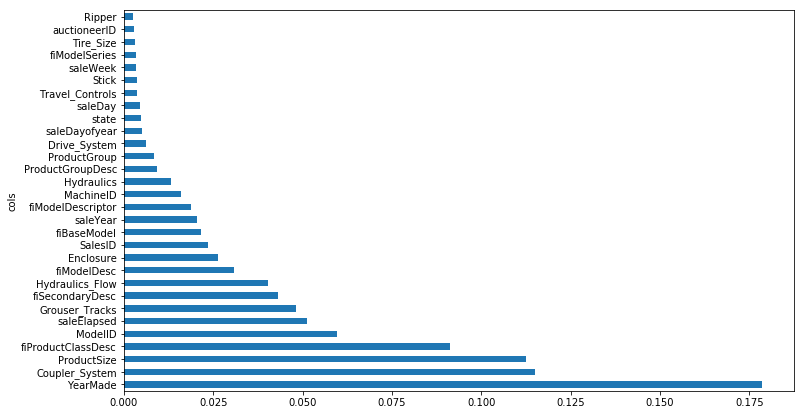

In [52]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(m, xs)

plot_fi(fi[:30]);

Above tells the relative feature importance of different features in our dataset.

Now once we have the feature importance of all the features calculated for our model, we can use this information to eliminate the features which are very less important, i.e. have feature importance value less than some threshold.

In [53]:
to_keep = fi[fi.imp>0.005].cols
print(f'We have reduced number of features from {df.shape[1]} to {len(to_keep)}')

We have reduced number of features from 65 to 20


In [54]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
print(f'Training error {m_rmse(m, xs_imp, y)}, Validation Error{m_rmse(m, valid_xs_imp, valid_y)}')

Training error 0.181062, Validation Error0.231971


We can see there isn't much change in the losses, but this has made our model quite simple with lesser data, $\frac{1}{3}^{rd}$ the original features.

### Redundant Features

We can calculate the Spearman Rank Correlation Coefficient for all the pair of columns, and if some columns have high correlation then we can take only one of them, and remove the other redundant feature. We can try experimenting with a different set of redundant features removed and chose the model with the least validation loss.

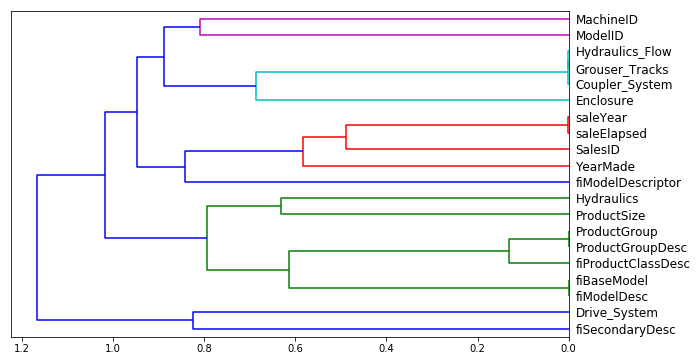

In [55]:
cluster_columns(xs_imp)

Those columns which are joined together in the left region have high correlation among them than the columns which are joined in the right. Therefore, 'saleYear' and 'saleElapsed' have a high correlation. 'ProductGroup' and 'ProductGroupDesc' also have a high correlation. We can try removing one of these pairs of columns.

In [56]:
to_drop=['saleYear', 'Grouser_Tracks', 'ProductGroup', 'fiBaseModel']

In [57]:
xs_imp_nr = xs_imp.drop(to_drop, axis=1)
valid_xs_imp_nr = valid_xs_imp.drop(to_drop, axis=1)
m = rf(xs_imp_nr, y)
print(f'Training error {m_rmse(m, xs_imp_nr, y)}, Validation Error{m_rmse(m, valid_xs_imp_nr, valid_y)}')

Training error 0.182557, Validation Error0.232808


In [58]:
print(f'We have reduced number of features from {xs_imp.shape[1]} to {xs_imp_nr.shape[1]}')

We have reduced number of features from 20 to 16


This has further reduced our number of features from 20 to 16, which will in turn make our model simpler, easy to debug, and more understandable. Improvements we have done so far have reduced the features and this is more or less the best we could do with RF.

### Relationship Between a Feature and Dependent Variable

Suppose we want to inspect how a feature impacts the dependent variable. E.g., we want to enquire about the relationship between 'YearMade' and 'salePrice'. One way could be we could simply find the average value of salePrice for every YearMade and plot the values, but that would be wrong. The reason being some of the other features could be impacting salePrice in some years but not in the other years.

As mentioned in fastai book, "Merely averaging over all the auctions that have the same YearMade would also capture the effect of how every other field also changed along with YearMade and how that overall change affected price."

The simple solution to find out a relationship is to replace all the YearMade in the dataset with one value, and then make predictions and take the average of those predictions. Similarly, replace one by one by all the years, and so we will get average salePrice value predictions for all the years.

In [59]:
yrs = xs_imp_nr.YearMade.unique()
yrs.sort()
yrs

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2014])

We have the above mentioned values for YearMade ranging from 1950 to 2014. We can replace all the YearMade values in the training dataset with 1950, and take the average of predictions, then replace with 1951 and take the average of predictions, similarly repeating for all the years in the domain of YearMade. The implementation is shown below.

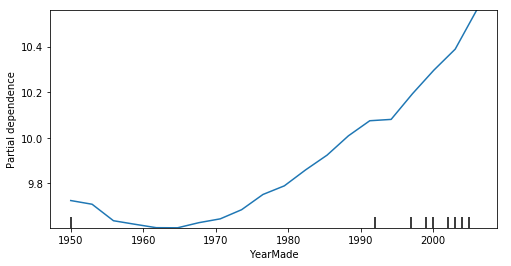

In [64]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(8, 4))
plot_partial_dependence(m, xs_imp_nr[:10000], ['YearMade'],
                        grid_resolution=20, ax=ax);

We can clearly see the salePrice is increasing almost linearly from 1963-64 to 2014. We are calculating the log of salePrice, therefore in fact the increase is exponential from 1963-64 to 2014 in salePrice value, which makes sense.

## Extrapolation Problem

As we did in PART I, we will construct a dataset and train an RF on it. Then will try to extrapolate on the out-of-domain data.

In [78]:
x = np.linspace(0, 10, 110)
y = x + np.random.randn(110)

tr_x, tr_y = x[:80], y[:80]
val_x, val_y = x[80:], y[80:]

tr_x = tr_x.reshape((80,1))
val_x = val_x.reshape((30,1))

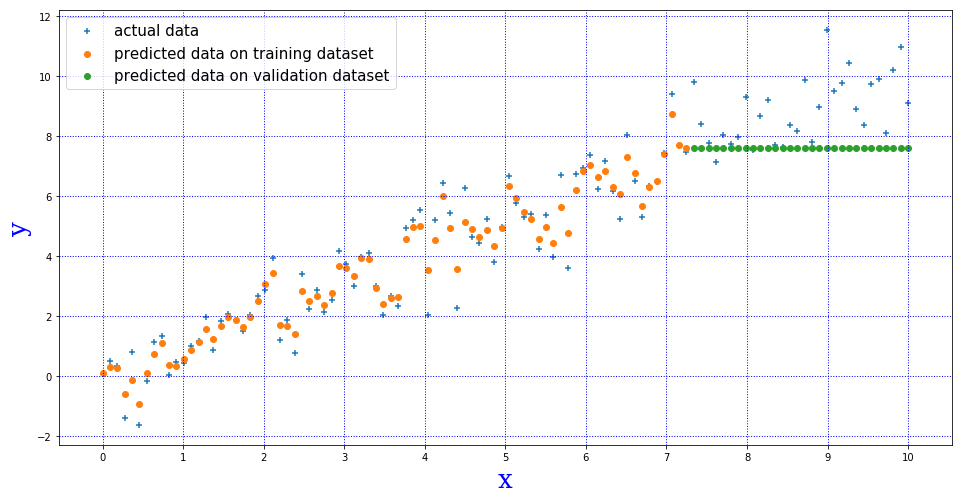

In [79]:
m = RandomForestRegressor()

m.fit(tr_x, tr_y);
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x,y, marker='+', label='actual data')
ax.scatter(tr_x, m.predict(tr_x), label='predicted data on training dataset')
ax.scatter(val_x, m.predict(val_x), label='predicted data on validation dataset')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.grid(which='major', axis='both', linestyle=':', linewidth = 1, color='b')


ax.set_xlabel("x", labelpad=5, fontsize=26, fontname='serif', color="blue")
ax.set_ylabel("y", labelpad=5, fontsize=26, fontname='serif', color="blue")
ax.legend(prop={"size":15})

We could see that RF has done better than a decision tree on the training set, and also it would have done better on in-domain new data. But for the out-of-domain dataset, suffers from the same problem as a decision tree. In the next part, we will look into NN and see what it has to offer on extrapolation.

## Conclusion
In PART II, we have covered Random Forests, done many improvements on it, and made training/validation losses lesser. 